In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from ipywidgets import interact, IntSlider

In [3]:
from read_results import read_varnames
import strato_code.kpp4py as kpp

In [4]:
nvar = 34
varnames = read_varnames("strato_code/strato_Parameters.f90")[0:nvar]
print(varnames)

['CH3', 'Cl2', 'Cl2O2', 'ClOO', 'OClO', 'BrCl', 'HOBr', 'BrONO2', 'HCO', 'CH3O', 'O1D', 'N2O5', 'HBr', 'CH3OOH', 'HNO4', 'HCl', 'H2O2', 'HOCl', 'HNO3', 'H', 'CH3O2', 'ClONO2', 'NO3', 'CH2O', 'Br', 'OH', 'Cl', 'ClO', 'O3', 'NO', 'BrO', 'O', 'HO2', 'NO2']


In [5]:
df_range = (
    pd.read_csv('strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['max'].loc['SUN'] = 0.0 # keep SUN fixed

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
OH,3.791087e+01,1.655987e+07,8.279952e+06,1.655983e+07
Cl,7.667911e-01,7.642127e+05,3.821067e+05,7.642119e+05
ClO,2.236826e+07,8.342272e+07,5.289549e+07,6.105446e+07
O3,4.342945e+11,5.292275e+11,4.817610e+11,9.493304e+10
NO,1.000000e-08,8.828713e+08,4.414357e+08,8.828713e+08
BrO,1.096853e+04,9.603792e+05,4.856739e+05,9.494107e+05
O,1.000000e-08,6.590324e+08,3.295162e+08,6.590324e+08
HO2,9.779919e+02,1.166693e+07,5.833955e+06,1.166595e+07
NO2,2.134505e+08,1.066423e+09,6.399367e+08,8.529723e+08
SUN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


# Make training data

In [6]:
shrink = 0.0

y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(5000, nvar+1))
y0_list.shape

(5000, 35)

In [7]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 3.28 s, sys: 28.7 ms, total: 3.31 s
Wall time: 3.33 s


(5000, 34)

# Normalize data

In [8]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:34])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
X_train = np.append(normalizer.transform(y0_list[:,0:34]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 35)

In [10]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([2.48897124e-03, 1.06450501e+00, 1.38816044e+00, 7.02462213e-05,
       1.14213213e+00, 1.10628071e+00, 1.57189743e+00, 1.06636751e+00,
       3.62402765e-03, 8.48246579e-07, 6.97220059e-14, 9.99782871e-01,
       9.92370556e-01, 1.18963018e+00, 1.36414809e+00, 1.00024107e+00,
       1.17777896e+00, 1.22385144e+00, 1.00982811e+00, 9.48637082e-05,
       5.75601423e-01, 1.01636005e+00, 3.48915873e-01, 9.95506678e-01,
       2.96752474e-03, 8.00012187e-03, 3.49379938e-05, 8.17688135e-01,
       1.00000039e+00, 2.96976397e-06, 3.79173190e-01, 4.07594976e-11,
       2.96324849e-01, 1.42667994e+00])

# Examine data

In [11]:
@interact(i=IntSlider(min=0,max=33,step=1,value=0,continuous_update=True))
def scatter_plot(i):
    plt.scatter(X_train[:,i], Y_train[:,i], s=0.2)
    plt.title(varnames[i])
    plt.xlabel('before')
    plt.ylabel('after')
    
    plt.plot([-2,2], [-2,2], c='k')
    plt.xlim(-2,2)
    plt.ylim(-2,2)

interactive(children=(IntSlider(value=0, description='i', max=33), Output()), _dom_classes=('widget-interact',…

# Fit ANN

In [12]:
x_torch = Variable(torch.from_numpy(X_train))
y_torch = Variable(torch.from_numpy(Y_train))

In [13]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(35, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 34)
).double()

In [14]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.02)

for t in range(100):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%10==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

10 0.0010086467922876326
20 0.00037151791527949144
30 0.00024250463717340054
40 0.00018965120092848977
50 0.00015912732330337662
60 0.00013901996213685239
70 0.00012573776547256986
80 0.0001146807772189429
90 0.00010689736818610348
100 0.00010066786871373183


In [15]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 45.4 ms, sys: 1.8 ms, total: 47.2 ms
Wall time: 16.8 ms


In [16]:
r2_score(y_pred_numpy, Y_train, multioutput='raw_values')

array([ 6.69292763e-01,  9.99867305e-01,  9.99935925e-01,  2.34811639e-03,
        9.99916313e-01,  9.99923556e-01,  9.99912214e-01,  9.99904985e-01,
        8.12883767e-01, -3.35623178e-04, -3.86713639e-05,  9.99870107e-01,
        9.99913368e-01,  9.99826005e-01,  9.99896328e-01,  9.99948776e-01,
        9.99845789e-01,  9.99914178e-01,  9.99919219e-01,  3.32551173e-03,
        9.99451262e-01,  9.99931607e-01,  9.93705095e-01,  9.99923965e-01,
        7.57943621e-01,  9.58373789e-01,  2.26538892e-03,  9.99929707e-01,
        9.99947464e-01, -8.74688042e-04,  9.99311077e-01, -7.61823986e-04,
        9.98917957e-01,  9.99960649e-01])

In [17]:
r2_score(y_pred_numpy, Y_train, multioutput='variance_weighted')

0.9998671810481524

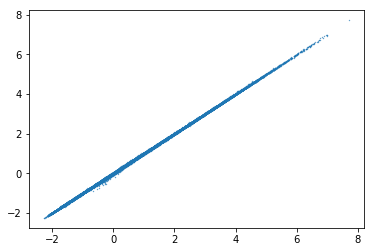

In [18]:
plt.scatter(y_pred_numpy, Y_train, s=0.1)

# Test set

In [19]:
shrink = 0.0

y0_test = np.random.uniform(df_range['min'] + shrink*df_range['span'],
                            df_range['max'] - shrink*df_range['span'], 
                            size=(5000, nvar+1))
y0_list.shape

(5000, 35)

In [20]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 3.23 s, sys: 15.4 ms, total: 3.24 s
Wall time: 3.24 s


In [21]:
X_test = np.append(normalizer.transform(y0_test[:,0:34]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [22]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 27.1 ms, sys: 3.09 ms, total: 30.2 ms
Wall time: 15.2 ms


In [23]:
r2_score(y_test_pred, Y_test, multioutput='variance_weighted')

0.9998389189978137

In [24]:
r2_test = r2_score(y_test_pred, Y_test, multioutput='raw_values')
r2_test

array([ 6.62128741e-01,  9.99833508e-01,  9.99928620e-01,  1.27219317e-03,
        9.99903631e-01,  9.99918989e-01,  9.99872104e-01,  9.99872333e-01,
        8.06135872e-01,  1.21912495e-04, -4.36997545e-04,  9.99847777e-01,
        9.99902244e-01,  9.99746892e-01,  9.99871256e-01,  9.99943442e-01,
        9.99809796e-01,  9.99892644e-01,  9.99903620e-01,  3.52918692e-03,
        9.99304065e-01,  9.99919190e-01,  9.93107890e-01,  9.99915513e-01,
        7.49491550e-01,  9.56522288e-01,  1.57014356e-03,  9.99925002e-01,
        9.99936083e-01, -3.35514203e-03,  9.99115458e-01, -1.25171342e-03,
        9.98854379e-01,  9.99955147e-01])

In [25]:
relerr = np.abs(y_test_pred/Y_test - 1) # relative error
relerr.mean(), relerr.max()

(0.051711714037409234, 2485.553905852674)

In [26]:
abserr = np.abs(y_test_pred-Y_test) # absolute error
abserr.mean(), abserr.max()

(0.006539437796618242, 0.2682235092665909)

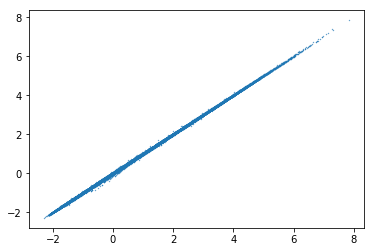

In [27]:
# plot all tracer together on a single figure
plt.scatter(y_test_pred, Y_test, s=0.1)

In [28]:
@interact(i=IntSlider(min=0,max=33,step=1,value=0,continuous_update=True))
def scatter_plot(i):
    plt.plot([-2,2], [-2,2], c='k', alpha=0.5)
    plt.scatter(y_test_pred[:,i], Y_test[:,i], s=0.2)
    plt.title(varnames[i])
    plt.xlabel('before')
    plt.ylabel('after')
    
    plt.xlim(-2,2)
    plt.ylim(-2,2)

interactive(children=(IntSlider(value=0, description='i', max=33), Output()), _dom_classes=('widget-interact',…